Step 1: Import library

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Install missing libraries
!pip install semopy

# ==========================
# Data & basic tools
# ==========================
import pandas as pd
import numpy as np

# ==========================
# Visualization
# ==========================
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================
# Statistical analysis
# ==========================
from scipy.stats import (
    ttest_ind,
    levene,
    chi2_contingency,
    skew,
    kurtosis,
    pearsonr,
    f_oneway
)
import statsmodels.api as sm

# ==========================
#  Structural Equation Modeling
# ==========================
from semopy import Model, calc_stats

# ==========================
# Time series modeling
# ==========================
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX

# ==========================
# Machine Learning (Random Forest)
# ==========================
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ==========================
# Deep Learning (LSTM)
# ==========================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 4.5 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659682 sha256=b0c97a17ef020d47e098e89e7aa60f854d196fe21e3c7df179dfdcee655e304c
  Stored in directory: /root/.cache/pip/wheels/c6/24/8b/be911b059a61f490f38425eb19bf2fed470a5ead97228e8255
Successfully built semopy


Step 2: Preprocess data

Step 2.1: Read data and drop some unused columns

In [3]:
df = pd.read_csv("/content/household.csv")

In [4]:
df = df.drop([
    'main',
    'description',
    'temp_min',
    'temp_max',
    'temp_t+1',
    'feels_like_t+1',
    'deg',
    'current',
    'voltage',
    'reactive_power',
    'apparent_power',
    'power_factor'
], axis=1)

Step 2.2: Load data and resample to hour

In [5]:

# change date column into datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date']).sort_values('date')

# merge data by hour (mean)
df_hour = (
    df.set_index('date')
      .resample('H')
      .mean(numeric_only=True)
      .reset_index()
)

print("The initial columns:", len(df), "→ After merging followed by hour:", len(df_hour))
df_hour

The initial columns: 249769 → After merging followed by hour: 4203


,date,active_power,temp,feels_like,pressure,humidity,speed
0,2022-11-05 14:00:00,248.780000,24.246364,23.728182,1011.909091,38.436364,0.081818
1,2022-11-05 15:00:00,202.663333,24.302000,23.765333,1010.666667,37.366667,2.912167
2,2022-11-05 16:00:00,198.863333,24.174000,23.605833,1011.416667,36.666667,2.322667
3,2022-11-05 17:00:00,390.181667,23.485667,22.830667,1010.600000,36.083333,2.455000
4,2022-11-05 18:00:00,443.036667,21.693667,20.933333,1008.816667,38.783333,2.269500
...,...,...,...,...,...,...,...
4198,2023-04-29 12:00:00,219.956667,18.381167,16.968167,1020.000000,26.550000,3.078333
4199,2023-04-29 13:00:00,399.270000,19.326833,18.044167,1019.633333,27.816667,3.215000
4200,2023-04-29 14:00:00,314.461667,20.383333,19.207833,1019.033333,28.100000,4.222833
4201,2023-04-29 15:00:00,418.894915,21.723729,20.507627,1015.440678,21.338983,3.524068


Step 2.3: Prepare some data columns

In [6]:


df_hour['weekday'] = df_hour['date'].dt.weekday
df_hour['is_weekend'] = df_hour['weekday'].isin([5,6]).astype(int)

# Lag features
df_hour['ap_lag_1h'] = df_hour['active_power'].shift(1)
df_hour['ap_lag_24h'] = df_hour['active_power'].shift(24)
df_hour['ap_roll_24h'] = df_hour['active_power'].rolling(24, min_periods=1).mean()
df_hour.dropna(inplace=True)

Step 2.4: View data

In [7]:
df_hour.head(1)

,date,active_power,temp,feels_like,pressure,humidity,speed,weekday,is_weekend,ap_lag_1h,ap_lag_24h,ap_roll_24h
24,2022-11-06 14:00:00,163.376667,28.653167,27.250167,1013.916667,21.083333,3.781167,6,1,224.355,248.78,273.720891


Step 3. Implement models

Step 3.1: Descriptive Statistical Analysis

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
active_power,4162.0,242.097,99.177,52.612,169.104,232.734,300.317,688.959,40.966,0.615,0.351
temp,4162.0,16.963,6.173,-4.000,12.863,16.705,21.118,32.248,36.388,-0.005,-0.263
feels_like,4162.0,15.933,6.253,-4.679,11.654,15.656,20.235,30.037,39.243,-0.055,-0.315
pressure,4162.0,1015.835,5.957,1000.600,1011.467,1015.508,1019.967,1032.900,0.586,0.221,-0.451
speed,4162.0,2.561,1.802,0.000,1.142,2.315,3.731,9.815,70.354,0.747,0.140
weekday,4162.0,2.980,1.996,0.000,1.000,3.000,5.000,6.000,66.994,0.013,-1.245
is_weekend,4162.0,0.281,0.450,0.000,0.000,0.000,1.000,1.000,159.934,0.974,-1.052
ap_lag_1h,4162.0,242.075,99.162,52.612,169.104,232.761,300.063,688.959,40.963,0.615,0.353
ap_lag_24h,4162.0,242.201,99.261,52.612,169.548,232.761,300.724,688.959,40.983,0.615,0.348
ap_roll_24h,4162.0,242.172,43.338,120.702,213.751,241.298,267.366,389.151,17.896,0.195,0.542


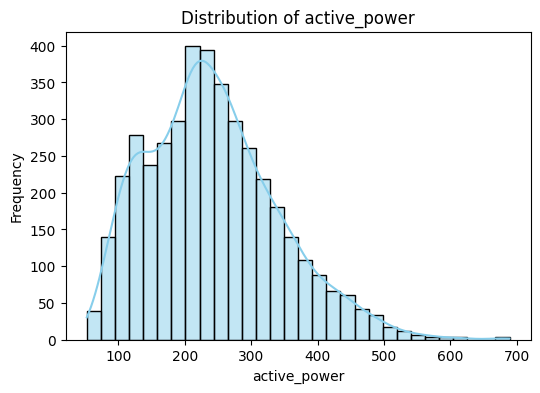

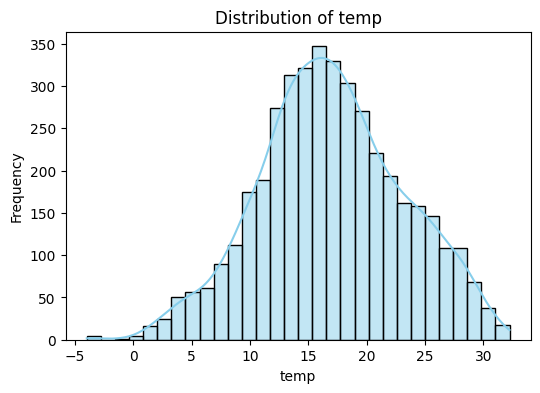

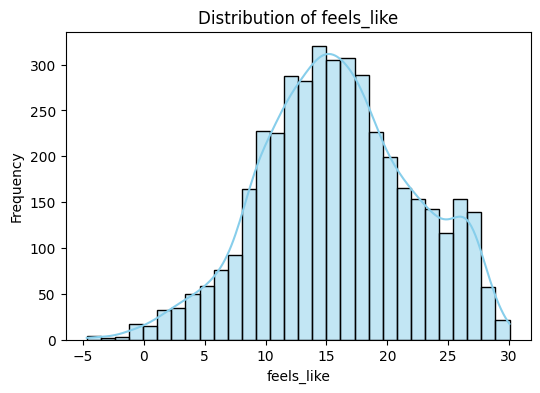

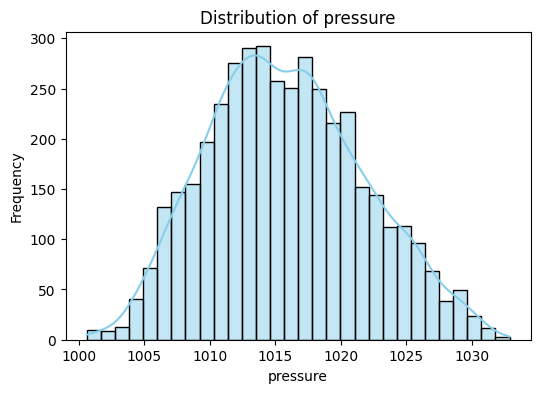

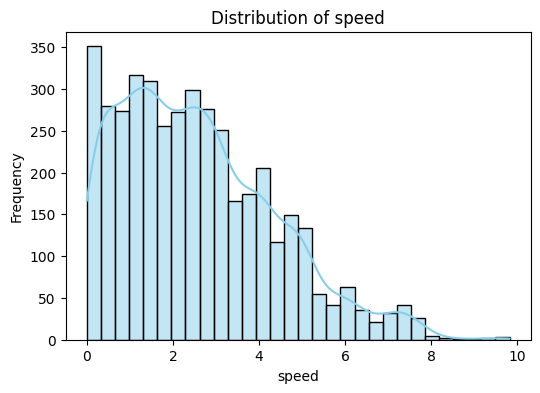

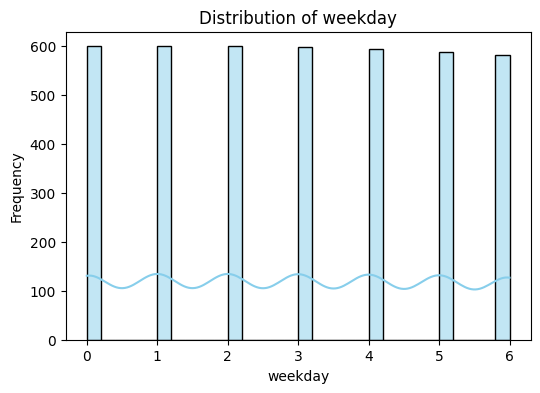

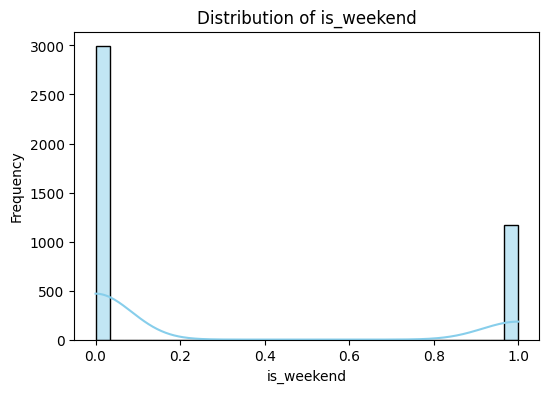

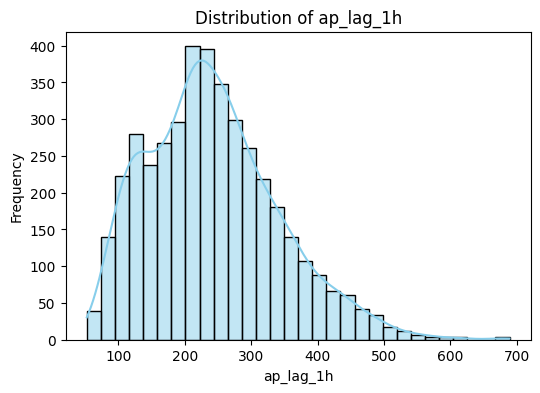

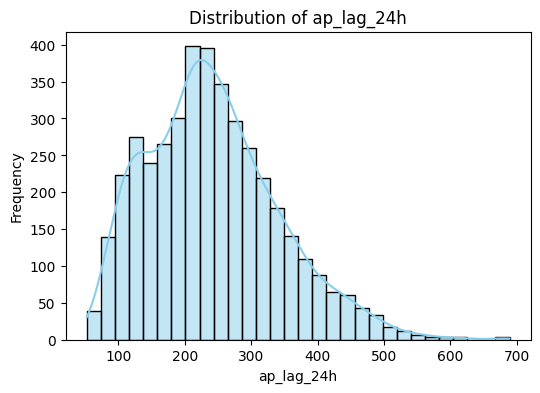

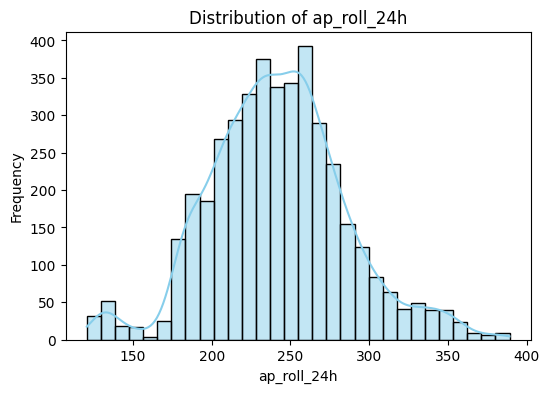

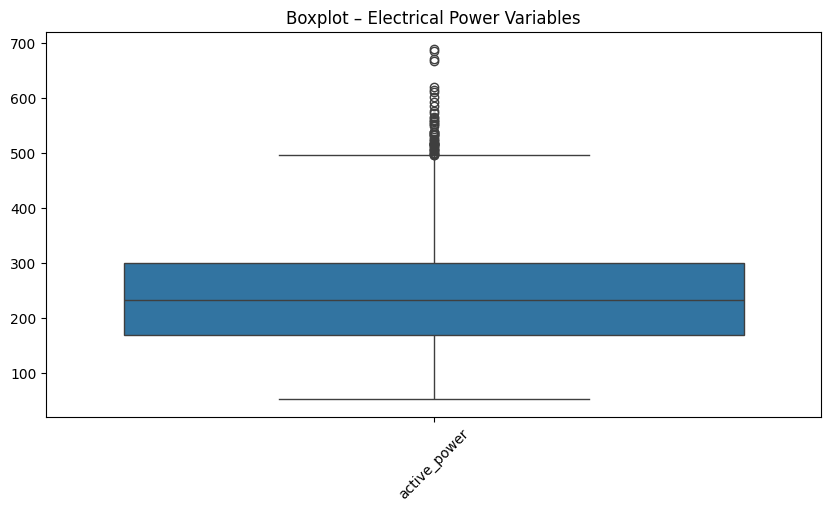

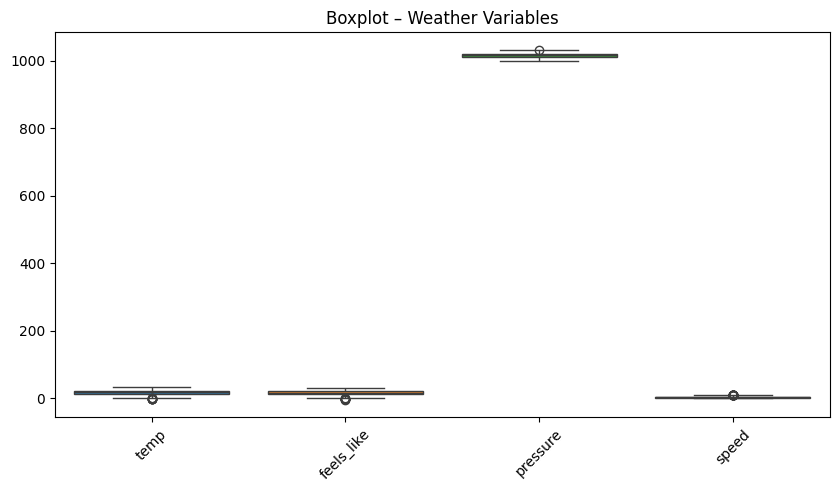

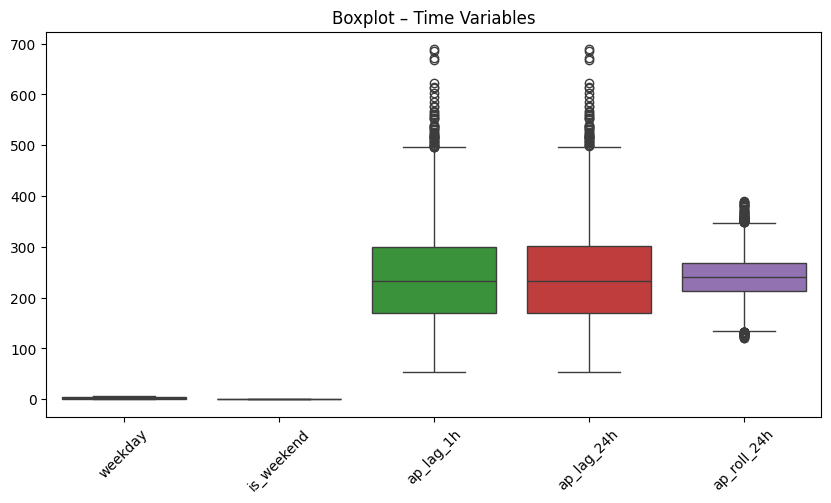

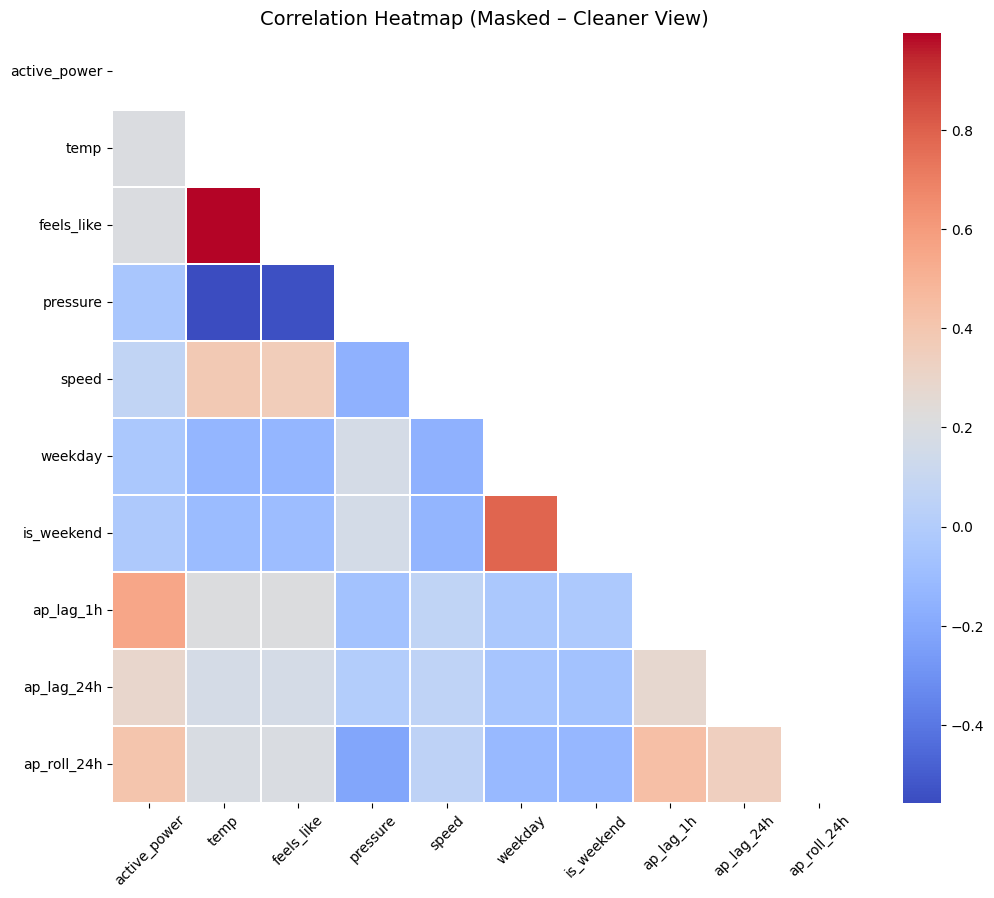

In [8]:

# Choose numeric columns for analysis
num_cols = ['active_power', 'temp', 'feels_like'
            ,'pressure', 'hudmidity', 'speed'
            , 'weekday', 'is_weekend', 'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create an empty DataFrame to hold the statistics
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round the statistics for better readability
stats = stats.astype(float).round(3)

# Show the descriptive statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Data Visualization
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot

#Power variables
power_vars = ['active_power']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[power_vars])
plt.title("Boxplot – Electrical Power Variables")
plt.xticks(rotation=45)
plt.show()

# Weather variables
weather_vars = ['temp','feels_like','pressure','speed']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[weather_vars])
plt.title("Boxplot – Weather Variables")
plt.xticks(rotation=45)
plt.show()

#  Time-derived variables
time_vars = ['weekday','is_weekend','ap_lag_1h','ap_lag_24h','ap_roll_24h']

plt.figure(figsize=(10,5))
sns.boxplot(data=df_hour[time_vars])
plt.title("Boxplot – Time Variables")
plt.xticks(rotation=45)
plt.show()



# Correlation heatmap
corr = df_hour[num_cols].corr()

plt.figure(figsize=(12,10))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,
            mask=mask,
            cmap='coolwarm',
            linewidths=0.3,
            annot=False)

plt.title("Correlation Heatmap (Masked – Cleaner View)", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()




=== OPTIMIZED ARIMAX GRID SEARCH ===
ARIMAX(0, 0, 0) → AIC=38243.42, MAE=66.7135, RMSE=83.6412
ARIMAX(0, 0, 1) → AIC=38070.17, MAE=69.2644, RMSE=87.3348
ARIMAX(0, 0, 2) → AIC=37851.34, MAE=103.3266, RMSE=127.6377
ARIMAX(0, 1, 0) → AIC=38246.48, MAE=494.8509, RMSE=668.8599
ARIMAX(0, 1, 1) → AIC=36558.14, MAE=832.6037, RMSE=1123.2535
ARIMAX(0, 1, 2) → AIC=36368.42, MAE=1041.2563, RMSE=1418.0975
ARIMAX(1, 0, 0) → AIC=38092.02, MAE=68.5264, RMSE=86.3644
ARIMAX(1, 0, 1) → AIC=36845.00, MAE=2070.2730, RMSE=2380.0560
ARIMAX(1, 0, 2) → AIC=38034.09, MAE=66.3190, RMSE=83.4642
ARIMAX(1, 1, 0) → AIC=37663.16, MAE=818.0714, RMSE=1113.8490
ARIMAX(1, 1, 1) → AIC=36367.89, MAE=923.7521, RMSE=1256.2029
ARIMAX(1, 1, 2) → AIC=36296.78, MAE=1036.1455, RMSE=1408.8474
ARIMAX(2, 0, 0) → AIC=37877.63, MAE=80.9140, RMSE=100.6612
ARIMAX(2, 0, 1) → AIC=37750.06, MAE=111.4196, RMSE=137.4138
ARIMAX(2, 0, 2) → AIC=37752.70, MAE=111.5277, RMSE=137.5406
ARIMAX(2, 1, 0) → AIC=36716.83, MAE=965.3718, RMSE=1294.3025
A

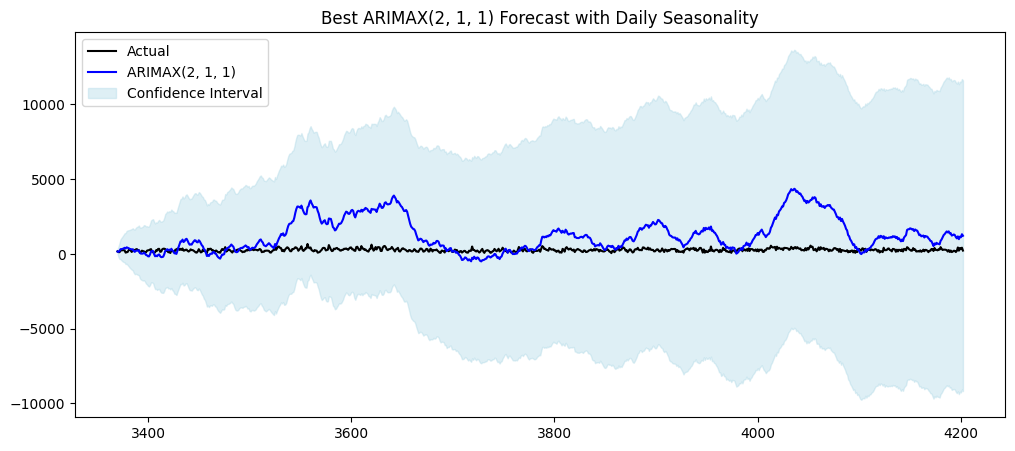

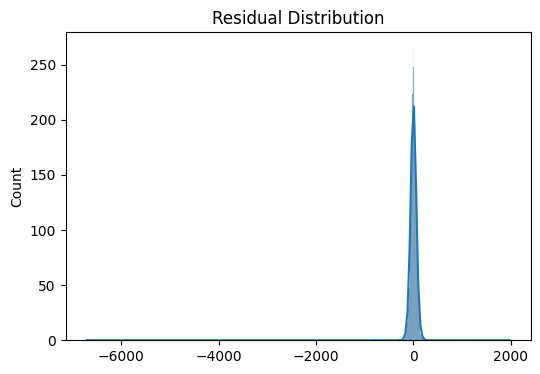

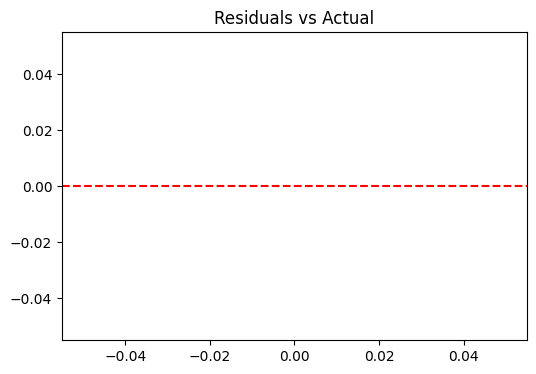

In [9]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("\n=== OPTIMIZED ARIMAX GRID SEARCH ===")

# Exogenous variables
exog_vars = [
    v for v in ['temp','humidity','pressure','speed',
                'ap_lag_1h','ap_lag_24h','ap_roll_24h']
    if v in df_hour.columns
]
exog = df_hour[exog_vars]

# Train/test split
split = int(len(df_hour) * 0.8)
y_train = df_hour['active_power'][:split]
y_test  = df_hour['active_power'][split:]
exog_train = exog[:split]
exog_test  = exog[split:]

# Grid search for ARIMA parameters
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
orders = list(product(p, d, q))

results = []

for order in orders:
    try:
        model = SARIMAX(
            y_train,
            exog=exog_train,
            order=order,
            seasonal_order=(1, 0, 0, 24),
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        res = model.fit(disp=False)

        pred = res.get_forecast(steps=len(y_test), exog=exog_test)
        y_pred = pred.predicted_mean

        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        results.append((order, res.aic, mae, rmse))
        print(f"ARIMAX{order} → AIC={res.aic:.2f}, MAE={mae:.4f}, RMSE={rmse:.4f}")

    except Exception as e:
        print(f"Skip ARIMAX{order} ({e})")
        continue

# Select best model
if len(results) > 0:
    results_sorted = sorted(results, key=lambda x: (x[1], x[2]))
    best_order, best_aic, best_mae, best_rmse = results_sorted[0]

    print(f"\nBest ARIMAX{best_order} → AIC={best_aic:.2f}, MAE={best_mae:.4f}, RMSE={best_rmse:.4f}")

    best_model = SARIMAX(
        y_train,
        exog=exog_train,
        order=best_order,
        seasonal_order=(1, 0, 0, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    best_res = best_model.fit(disp=False)
    best_pred = best_res.get_forecast(steps=len(y_test), exog=exog_test)
    y_best_pred = best_pred.predicted_mean
    conf_int = best_pred.conf_int()

    # Forecast plot
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.index, y_test.values, label='Actual', color='black')
    plt.plot(y_test.index, y_best_pred.values, label=f'ARIMAX{best_order}', color='blue')
    plt.fill_between(
        y_test.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color='lightblue',
        alpha=0.4,
        label='Confidence Interval'
    )
    plt.legend()
    plt.title(f'Best ARIMAX{best_order} Forecast with Daily Seasonality')
    plt.show()

    # Residual diagnostics
    residuals = best_res.resid

    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title("Residuals vs Actual")
    plt.show()

else:
    print("No ARIMAX model fitted successfully.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.0313 - val_loss: 0.0226
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0224 - val_loss: 0.0215
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0211 - val_loss: 0.0208
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0204 - val_loss: 0.0200
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0200 - val_loss: 0.0193
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0199 - val_loss: 0.0190
Epoch 9/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0188 - val_loss: 0.0183
Epoch 10/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0192 - val_loss: 0.0179
Epoch 11/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0180 - val_loss: 0.0177
Epoch 12/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0

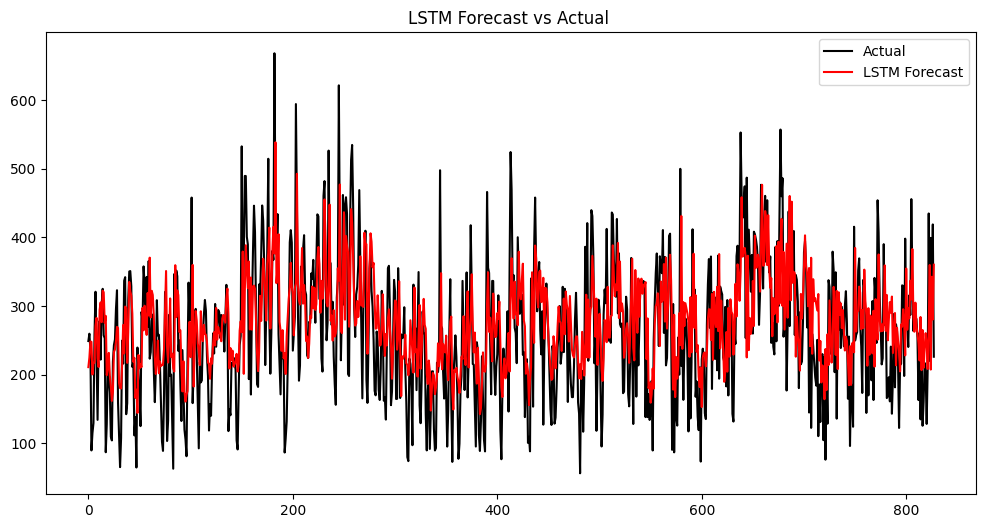

In [10]:


# ================================
# 1. Select features for LSTM
# ================================
features = ['active_power', 'temp', 'humidity', 'pressure', 'speed',
            'ap_lag_1h', 'ap_lag_24h', 'ap_roll_24h']

df_lstm = df_hour[features].copy().dropna()

# ================================
# 2. Scale the data
# ================================
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_lstm)

# ================================
# 3. TCreate sequences (windows)
# ================================
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])   # column 0 = active_power
    return np.array(X), np.array(y)

window_size = 24   # use the past 24 hours to forecast the next hour

X, y = create_sequences(scaled_data, window_size)

# ================================
# 4. TRAIN/TEST SPLIT
# ================================
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ================================
# 5. Build the LSTM model
# ================================
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(32))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

# ================================
# 6. TRAIN MODEL
# ================================
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.1,
                    verbose=1)

# ================================
# 7. Forecasting
# ================================
y_pred = model.predict(X_test)

# Inverse scale prediction
test_scaled = np.zeros((len(y_pred), scaled_data.shape[1]))
test_scaled[:, 0] = y_pred[:, 0]

y_pred_inv = scaler.inverse_transform(test_scaled)[:, 0]
y_test_inv = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1,1), np.zeros((len(y_test), scaled_data.shape[1]-1))], axis=1)
)[:, 0]

# ================================
# 8. Evaluation
# ================================
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"LSTM → MAE={mae:.4f}, RMSE={rmse:.4f}")

# ================================
# 9. Plot the results
# ================================
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Actual', color='black')
plt.plot(y_pred_inv, label='LSTM Forecast', color='red')
plt.legend()
plt.title("LSTM Forecast vs Actual ")
plt.show()
